In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats, special
from numpy import random
from collections import namedtuple, Counter

np.set_printoptions(precision=2)

In [2]:
def generate(weights, means, var, N):
    """Generate data from a mixture model with fixed mean variance
    """
    samples = []
    components = []
    assert(len(weights) == len(means))
    assert(sum(weights) == 1)
    for i in range(N):
        component = random.choice(range(len(means)), p=weights)
        samples.append(random.normal(means[component], np.sqrt(var)))
        components.append(component)
    return np.array(samples), np.array(components)


def group_data(X, c):
    return {cluster: 
            [x for x, assignment in zip(X, c) 
             if assignment == cluster] 
            for cluster in set(c)}


def shuffle(state):
    z = list(zip(state['data'], state['c']))
    random.shuffle(z)
    state['data'], state['c'] = map(list, zip(*z))
    return state


def state_score(state):
    """Total likelihood of state
    """
    cluster_labels = state['suffstats'].keys()
    a = np.array([suffstat_score(cluster, state) 
                  for cluster in cluster_labels])

    b = np.array([cluster_assign_score(cluster, state) 
                  for cluster in cluster_labels])
    return (a + b).sum()

In [3]:
SuffStat = namedtuple('SuffStat', 'N mu')

def generate_suffstat(X):
    X = np.array(X)
    return SuffStat(N=len(X), mu=X.mean())


def add_datapoint_to_suffstats(x, ss):
    """Update sufficient stats for normal component with new datapoint
    """
    N = ss.N + 1
    mu = (ss.mu * (N - 1) + x) / N
    return SuffStat(N, mu)


def remove_datapoint_from_suffstats(x, ss):
    """Remove datapoint from sufficient stats for normal component
    """
    N = ss.N - 1
    mu = (ss.mu * (N + 1) - x * 1.0) / N
    return SuffStat(N, mu)


def suffstat_score(cluster, state):
    """p(D) Murphy eq 55
    """
    X = [x for x, cluster2 in zip(state['data'], state['c']) if cluster2 == cluster]
    xx = np.square(np.array(X)).sum()
    ss = state['suffstats'][cluster]
    mu_0, sigmasq_0, param_var = state['mu_0'], state['sigmasq_0'], state['param_var']
    sigma = np.sqrt(param_var)
    denom = (2 * (ss.N * sigmasq_0 + param_var))
    terms = np.array([np.log(sigma),
                      -np.log((np.sqrt(2*np.pi)*sigma)**ss.N * np.sqrt(ss.N*sigmasq_0 + param_var)),
                      -xx * 1. / (2 * param_var),
                      -mu_0**2 * 1. / (2 * sigmasq_0),
                      sigmasq_0 * ss.N**2 * ss.mu**2 * 1. / param_var / denom,
                      param_var * mu_0**2 * 1. / sigmasq_0 / denom,
                      2. * ss.N * ss.mu * mu_0 / denom
                      ])
    return np.array(terms).sum()
    

def cluster_assign_score(cluster, state):
    """From Algorithm 24.1 in Murphy 2012
    
    What is the probability of the datapoint being in cluster?
    """
    current_cluster_size, num_clusters, alpha = state['suffstats'][cluster].N, state['K'], state['alpha']
    return np.log(current_cluster_size - 1 + alpha * 1. / num_clusters)


def posterior_predictive_score(x, cluster, state):
    """From Section 2.3 of http://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
    """
    ss = state['suffstats'][cluster]
    sigmasq_0 = state['sigmasq_0']
    mu_0 = state['mu_0']
    param_var = state['param_var']
    posterior_sigma2 = 1 / (ss.N * 1. / param_var + 1. / sigmasq_0)
    predictive_mu = posterior_sigma2 * (mu_0 * 1. / sigmasq_0 + ss.N * ss.mu * 1. / param_var)
    predictive_sigma2 = param_var + posterior_sigma2
    predictive_sd = np.sqrt(predictive_sigma2)
    return stats.norm(predictive_mu, predictive_sd).logpdf(x)


def sample_marginalized_parameters(state):
    alpha = state['alpha']
    num_clusters = state["K"]
    mu_0, sigmasq_0, param_var = state['mu_0'], state['sigmasq_0'], state['param_var']
    pi = stats.dirichlet([ss.N + alpha * 1.0 / num_clusters for ss in state["suffstats"].values()]).rvs()[0]
    mus = []
    for cluster, ss in state["suffstats"].iteritems():
        numerator = (mu_0 / sigmasq_0 + 
                     ss.mu * ss.N / param_var)
        denominator = (1.0 / sigmasq_0 + ss.N / param_var)
        posterior_mu = numerator / denominator
        posterior_sigma2 = 1.0 / (1.0 / sigmasq_0 + ss.N)
        mus.append(stats.norm(posterior_mu, np.sqrt(posterior_sigma2)).rvs())
    return pi, np.array(mus)

In [4]:
def gibbs_step(state, infer_mu0=True):
    state = shuffle(state)
    K = len(state['suffstats'])
    for i, (datapoint, cluster) in enumerate(zip(state['data'], state['c'])):

        state['suffstats'][cluster] = remove_datapoint_from_suffstats(datapoint, 
                                                                      state['suffstats'][cluster])
        cluster_labels = state['suffstats'].keys()
        t = [posterior_predictive_score(0, cluster, state)
                             for cluster in cluster_labels]
        predictive_scores = [posterior_predictive_score(datapoint, cluster, state)
                             for cluster in cluster_labels]
        cluster_scores = [cluster_assign_score(cluster, state)
                          for cluster in cluster_labels]
        scores = np.array(predictive_scores) + np.array(cluster_scores)
        scores = np.exp(scores) / np.exp(scores).sum()
        new_cluster = random.choice(cluster_labels, p=scores)
        state['c'][i] = new_cluster
                
        state['suffstats'][new_cluster] = add_datapoint_to_suffstats(datapoint, state['suffstats'][new_cluster])
        
    if infer_mu0:
        current_prior_mu = state['mu_0']
        current_score = state_score(state)
        state['mu_0'] = current_prior_mu + random.normal(scale=.1)
        proposal_score = state_score(state)
        diff = min(proposal_score - current_score, 0)
        if np.log(stats.uniform(0, 1).rvs()) < diff:
            pass
        else:
            state['mu_0'] = current_prior_mu
    return state

In [5]:
def initial_state(N=200):
    state = {'data' : None, 
             'c' : None, 
             'suffstats' : None, 
             'mu_0' : 0, 
             'sigmasq_0' : 1, 
             'param_var' : .3,
             'alpha': 1}
    ground_truth_weights, ground_truth_means = [.3, .2, .5], [-2, 0, 2]
    state["K"] = len(ground_truth_means)
    state['data'], ground_truth_c = generate(ground_truth_weights, ground_truth_means, state["param_var"], N)
    state['c'] = [random.choice(range(state["K"])) for _ in state['data']]
    grouped_data = group_data(state['data'], state['c'])

    state['suffstats'] = {cluster: generate_suffstat(X) for cluster, X in grouped_data.iteritems()}
    return state, ground_truth_c

{0: SuffStat(N=63, mu=-1.9288726957665485),
 1: SuffStat(N=47, mu=0.010342055351286999),
 2: SuffStat(N=90, mu=2.0179126512901222)}

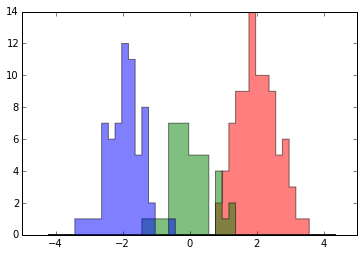

In [6]:
state, ground_truth_c = initial_state()
bins = np.arange(min(state['data'])-1, max(state['data'])+1, .2)
_ = plt.hist(group_data(state['data'], ground_truth_c).values(), 
             bins=bins, 
             histtype='stepfilled', alpha=.5)

{cluster: generate_suffstat(X) for cluster, X in group_data(state['data'], ground_truth_c).iteritems()}

In [7]:
num_iterations = 250
scores = []
samples = []
for i in range(num_iterations):
    state = gibbs_step(state)
    pi, mu = sample_marginalized_parameters(state)
    samples.append({
        "mu_0": state["mu_0"],
        "c": np.array(state["c"]),
        "mu": mu,
        "pi": pi
    })
    scores.append(state_score(state))

### Model Score

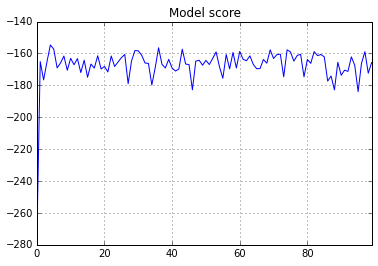

In [8]:
pd.Series(scores[:100]).plot(title="Model score")

### Cluster Means Distributions

In [9]:
mus = np.array([p["mu"] for p in samples])

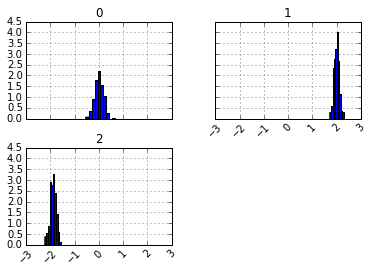

In [10]:
_ = pd.DataFrame(mus).hist(normed=True, xrot=45, sharey=True, sharex=True)

### $\mu_0$ Distribution

In [11]:
mu0 = np.array([p["mu_0"] for p in samples])

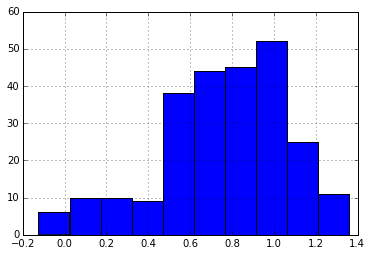

In [12]:
pd.Series(mu0).hist()

### $\pi$ Distribution

In [16]:
pd.DataFrame(pi).describe()

,0,1,2
count,250.000000,250.000000,250.000000
mean,0.214253,0.458805,0.326942
std,0.033528,0.037043,0.035381
min,0.088164,0.338972,0.224987
25%,0.193370,0.432467,0.301983
50%,0.214224,0.459338,0.324142
75%,0.236366,0.480968,0.347784
max,0.323687,0.584172,0.432516


In [15]:
pi.mean(axis=0)

array([ 0.21,  0.46,  0.33])

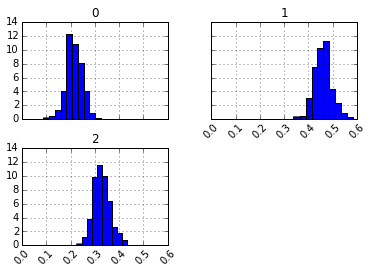

In [13]:
pi = np.array([p["pi"] for p in samples])
_ = pd.DataFrame(pi).hist(normed=True, xrot=45, sharey=True, sharex=True)